In [1]:
!pip install multidict -q #efficientnet_pytorch

In [2]:
import pandas as pd
import numpy as np
import os
os.environ['WANDB_API_KEY'] = 'cb2feee46a2bfa33da14728baf59ccb43834ec13'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

# from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader, Sampler
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models

from numba import jit

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
from multidict import MultiDict

import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
# для получения label для каждого файла
class_dict = {
    'GP': 0, 'G': 1, 'M': 2, 'T': 3, 'clear': 4 # выкинуть один класс - clear
}

# class_dict = {
#     '-20':0, '-25':1, '-30':2, '-35':3
# }

def get_class_from_path(path, class_dict=class_dict):
    for key in class_dict:
        if key in path:
            return class_dict[key]

In [4]:
root_dir = '/kaggle/input/lozzzz/all_images'
image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

new_img_files = []
labels = []
for elem in image_files:
    for key in class_dict:
        if key in elem:
            labels.append(class_dict[key])
            new_img_files.append(elem)
            break
        else:
            continue

In [5]:
train_paths, valid_paths = train_test_split(new_img_files, random_state=42, shuffle=True, train_size=0.7, stratify=labels)

In [6]:
labels_train = []
for elem in train_paths:
    for key in class_dict:
        if key in elem:
            labels_train.append(class_dict[key])
            break

In [7]:
from collections import Counter
Counter(labels_train)

class_counts = [106, 104, 89, 99, 59]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights /= class_weights.sum()

In [8]:
@jit(nopython=True)
def cutting_images(image: np.array, tile_width: int, tile_height: int, k_false: int = 5, n_true: int = 1, central: bool = True):
    height, width = image.shape[:2]

    fragments = []

    if central:
        center_x = width // 2
        center_y = height // 2
        start_x = center_x - (tile_width * n_true) // 2
        start_y = center_y - (tile_height * n_true) // 2

        for i in range(n_true):
            for j in range(n_true):
                left = start_x + i * tile_width
                upper = start_y + j * tile_height
                fragment = image[upper:upper+tile_height, left:left+tile_width]
                fragments.append(fragment)
    else:
        x_coords = np.arange(0, width - tile_width + 1, tile_width)
        y_coords = np.arange(0, height - tile_height + 1, tile_height)

        total_fragments = len(x_coords) * len(y_coords)
        k_false_adjusted = min(k_false, total_fragments)
        selected_indices = np.random.choice(total_fragments, k_false_adjusted, replace=False)

        for idx in selected_indices:
            start_x = x_coords[idx % len(x_coords)]
            start_y = y_coords[idx // len(x_coords)]
            fragment = image[start_y:start_y+tile_height, start_x:start_x+tile_width]
            fragments.append(fragment)

    return fragments

In [9]:
# обрезаем хвосты и заменяем их на 0 и 1
def cut_percentiles(image):
    q1 = np.percentile(image, 1)
    q99 = np.percentile(image, 99)

    image[image < q1] = 0
    image[image > q99] = 1
    return image

def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 75, 75)

# применение bilateral filter
def apply_bilateral_filter_to_normalized(image):
    image_8bit = (image * 255).astype(np.uint8)
    return bilateral_filter(image_8bit) / 255.0

In [10]:
class LozDataset(Dataset):
    def __init__(self, root_dir, image_files, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(self.root_dir, image_file) for image_file in image_files]
        self.total_fragments = sum([cutting_images(np.zeros((1704, 2272)), tile_width=224, tile_height=224, n_true=3, central=True) for _ in self.image_files], [])
        
    def __len__(self):
        return len(self.total_fragments)

    def __getitem__(self, idx):
        fragments_per_image = len(cutting_images(np.zeros((1704, 2272)), tile_width=224, tile_height=224, n_true=3, central=True))
        image_idx = idx // fragments_per_image
        fragment_idx = idx % fragments_per_image
        
        img_name = self.image_files[image_idx]
        image = Image.open(img_name).convert('L')
        image_np = np.array(image)
        
        fragments = cutting_images(image=image_np, tile_width=224, tile_height=224, n_true=3, central=True)
        fragment = fragments[fragment_idx]
        
        # нормализуем фрагмент
        max_value = np.max(fragment)
        normalized_fragment = fragment / max_value
        fragment = cut_percentiles(normalized_fragment)
        fragment = apply_bilateral_filter_to_normalized(fragment)
        
        if self.transform:
            fragment = self.transform(image=fragment)['image']
        
        label = get_class_from_path(img_name)
        image_t = torch.tensor(fragment, dtype=torch.float32)

        return image_t, img_name, label

In [11]:
# соль и перец
class SaltAndPepper(A.ImageOnlyTransform):
    def __init__(self, p=1., salt_ratio=0.5, amount=0.0008, always_apply=True):
        super().__init__(always_apply, p)
        self.salt_ratio = salt_ratio
        self.amount = amount

    def apply(self, image, **params):
        image_copy = np.copy(image)  # создание копии изображения

        num_salt = np.ceil(self.amount * image.size * self.salt_ratio)
        coords_salt = [np.random.randint(0, i - 1, int(num_salt)) for i in image_copy.shape]
        image_copy[coords_salt[0], coords_salt[1]] = 220

        num_pepper = np.ceil(self.amount * image.size * (1.0 - self.salt_ratio))
        coords_pepper = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_copy.shape]
        image_copy[coords_pepper[0], coords_pepper[1]] = 0

        return image_copy

In [12]:
train_transform = A.Compose([
    A.HorizontalFlip(p=.3),
#     A.RandomBrightnessContrast(p=1, contrast_limit=(.2), brightness_by_max=True, brightness_limit=(.2)),
    A.Rotate(limit=30, p=.3),
#     A.GaussianBlur(p=1, blur_limit=(1,3)),
#     A.CoarseDropout(max_holes=6, p=1., fill_value=200, max_height=3, max_width=3),
#     A.CoarseDropout(max_holes=6, p=1., fill_value=0, max_height=3, max_width=3),
#     A.GaussNoise(var_limit=(10.0), p=1), #белый шум
#     SaltAndPepper(salt_ratio=0.0),
    A.ElasticTransform(alpha=2, sigma=20, alpha_affine=10, p=.4),
])

# valid_transform = A.Compose([
#     A.Normalize(mean=[mean/255.0], std=[std/255.0]),
# ])

In [13]:
root_dir = '/kaggle/input/lozzzz/all_images'
train_dataset = LozDataset(root_dir, train_paths, transform=train_transform)
valid_dataset = LozDataset(root_dir, valid_paths)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=True)

In [15]:
NUM_CLASSES = len(class_dict)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mobilenet_v2_model = models.mobilenet_v2(pretrained=True)
mobilenet_v2_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, NUM_CLASSES)
mobilenet_v2_model = mobilenet_v2_model.to(device)

if torch.cuda.device_count() > 1:
    mobilenet_v2_model = torch.nn.DataParallel(mobilenet_v2_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 49.4MB/s]


In [16]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# criterion = FocalLoss(alpha=.8)

optimizer = torch.optim.AdamW(mobilenet_v2_model.parameters())
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.6)

In [17]:
import wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="first_expirement",
    
    # track hyperparameters and run metadata
    config={
        "architecture": "mobilenet-v2",
        "dataset": "lozz",
        "epochs": 30,
        "fragments": 9,
        "central": True,
        "batch_size": 16,
        "classes": 5,
        "preprocessing": "normalizing and bilateral filter",
        "augmentations": """
                        A.HorizontalFlip(p=.3),
                    #     A.RandomBrightnessContrast(p=1, contrast_limit=(.2), brightness_by_max=True, brightness_limit=(.2)),
                        A.Rotate(limit=30, p=.3),
                    #     A.GaussianBlur(p=1, blur_limit=(1,3)),
                    #     A.CoarseDropout(max_holes=6, p=1., fill_value=200, max_height=3, max_width=3),
                    #     A.CoarseDropout(max_holes=6, p=1., fill_value=0, max_height=3, max_width=3),
                    #     A.GaussNoise(var_limit=(10.0), p=1), #белый шум
                        SaltAndPepper(salt_ratio=0.0),
                        A.ElasticTransform(alpha=2, sigma=20, alpha_affine=10, p=.4),
                        """,
        "optimizer": 'torch.optim.AdamW(mobilenet_v2_model.parameters())',
        "criterion": 'nn.CrossEntropyLoss(weight=class_weights.to(device))',
        "sheduler": 'torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.6)'
    }
)

wandb: Currently logged in as: danzzzll. Use `wandb login --relogin` to force relogin


In [18]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

def train_and_validate(epoch):
                                                ### train
    print(f'EPOCH: {epoch + 1}')
    running_loss = 0.0
    running_acc = 0.0
    mobilenet_v2_model.train()
    for batch_idx, (data, name, target) in tqdm(enumerate(train_dataloader)):
        target = target.type(torch.LongTensor)
        
        data = data.unsqueeze(1)
        data, target = data.to(device).float(), target.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2_model(data)
    
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_acc += (preds == target).float().mean().item()
        
        if batch_idx % 100 == 0:
            random_img = data.cpu().numpy()[np.random.randint(data.size(0))][0]
            plt.imshow(random_img, cmap='gray')
            plt.title("Random Image from Batch")
            plt.axis('off')
            plt.show()
    
    train_loss.append(running_loss / len(train_dataloader))
    train_acc.append(running_acc / len(train_dataloader))
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, ")
    exp_lr_scheduler.step()
    
                                                ### validate

    mobilenet_v2_model.eval()
    all_preds = [] # для сохранения всех предсказаний
    all_targets = [] # для сохранения всех истинных значений
    with torch.no_grad():
        running_acc = 0.0
        for batch_idx, (data, name, target) in enumerate(valid_dataloader):
            data = data.unsqueeze(1)
            data, target = data.to(device), target.to(device)
            data = data.float()

            outputs = mobilenet_v2_model(data)

            loss = criterion(outputs, target)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            running_acc += (preds == target).float().mean().item()

            # сохранение истинных значений и предсказаний
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            

    test_loss.append(running_loss / len(valid_dataloader))
    test_acc.append(running_acc / len(valid_dataloader))
    
    print(f"Epoch {epoch+1}, Valid Loss: {test_loss[-1]:.3f}, Valid Acc: {test_acc[-1]:.3f}, ")
    
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    wandb.log({"train_acc": train_acc[-1], "train_loss": train_loss[-1], "valid_acc": test_acc[-1], "valid_loss": test_loss[-1]})
    return train_loss, train_acc, test_loss, test_acc

EPOCH: 1


0it [00:00, ?it/s]

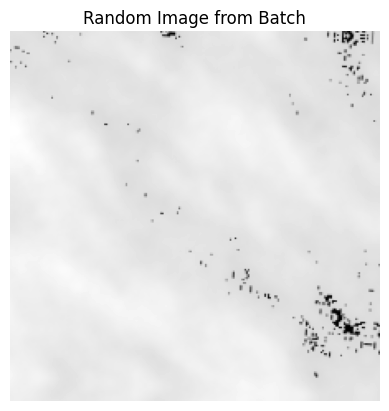

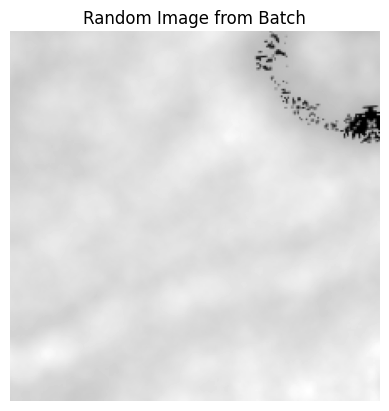

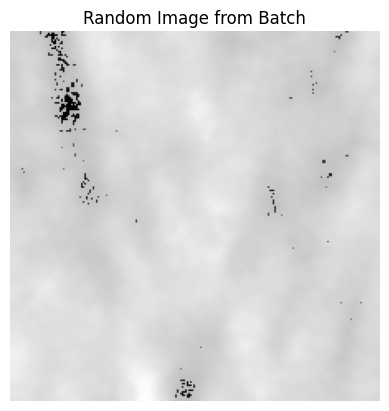

Epoch 1, Train Loss: 1.382, Train Acc: 0.383, 
Epoch 1, Valid Loss: 4.763, Valid Acc: 0.355, 


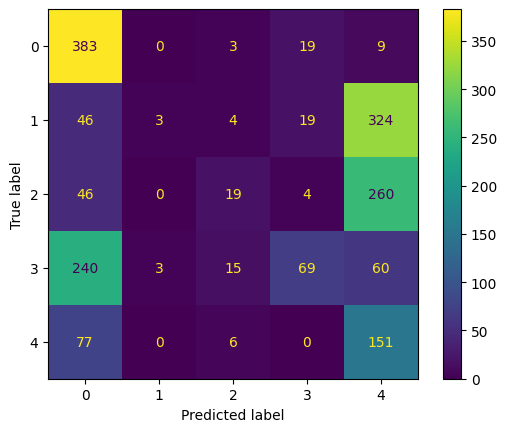

EPOCH: 2


0it [00:00, ?it/s]

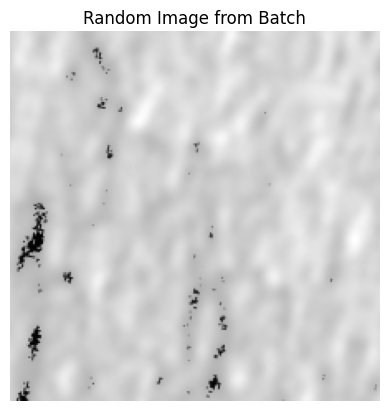

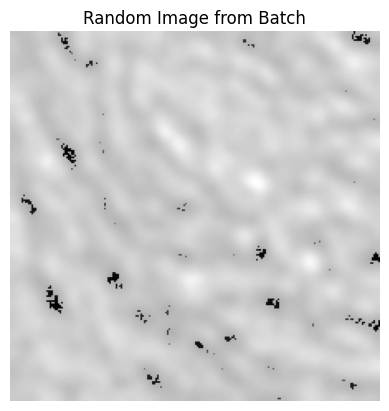

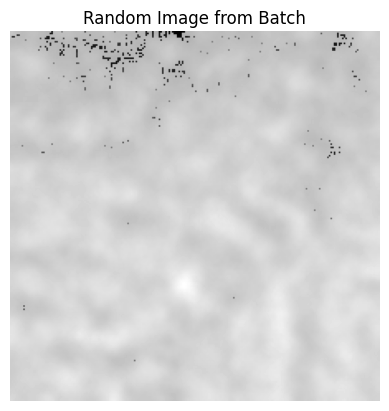

Epoch 2, Train Loss: 1.289, Train Acc: 0.403, 
Epoch 2, Valid Loss: 4.199, Valid Acc: 0.502, 


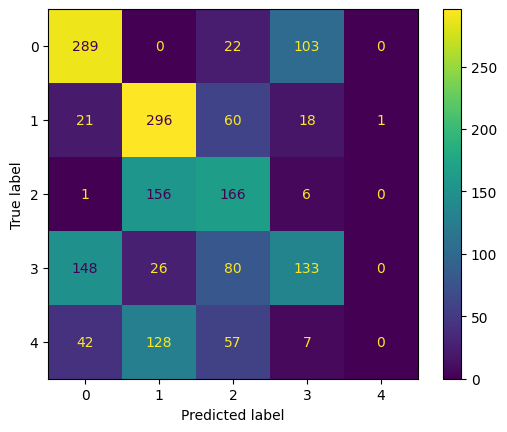

EPOCH: 3


0it [00:00, ?it/s]

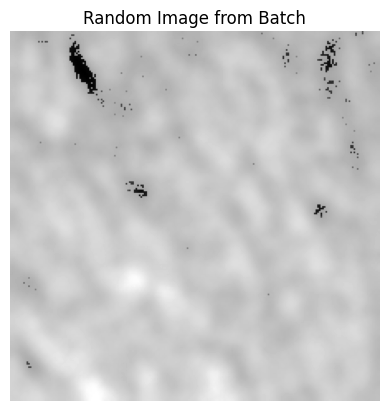

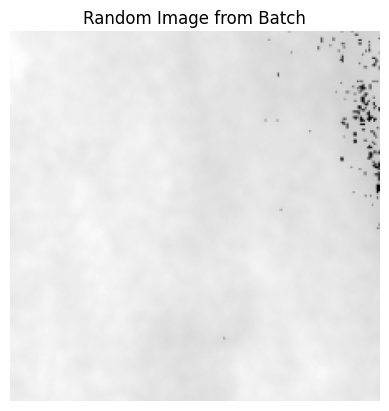

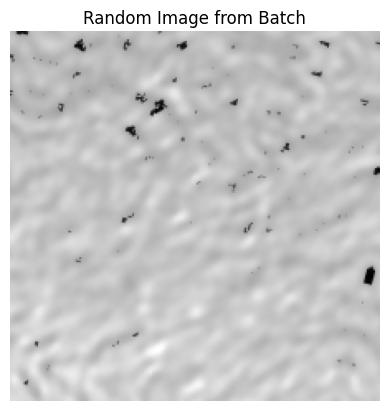

Epoch 3, Train Loss: 1.250, Train Acc: 0.432, 
Epoch 3, Valid Loss: 4.068, Valid Acc: 0.480, 


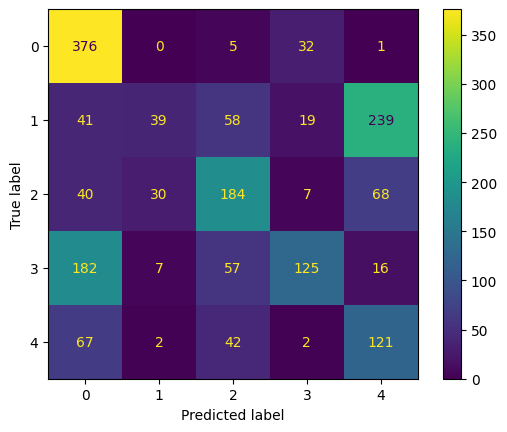

EPOCH: 4


0it [00:00, ?it/s]

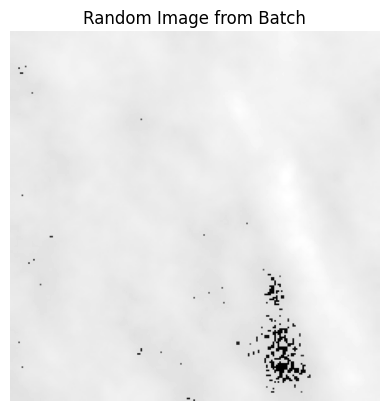

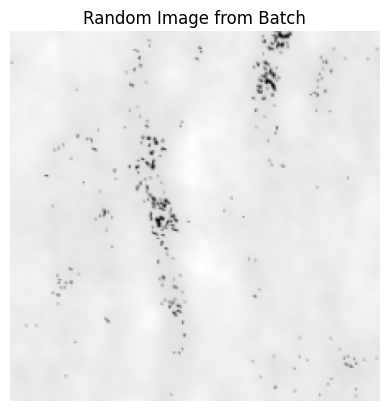

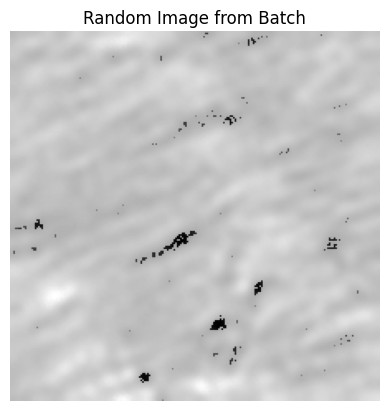

Epoch 4, Train Loss: 1.229, Train Acc: 0.450, 
Epoch 4, Valid Loss: 4.015, Valid Acc: 0.542, 


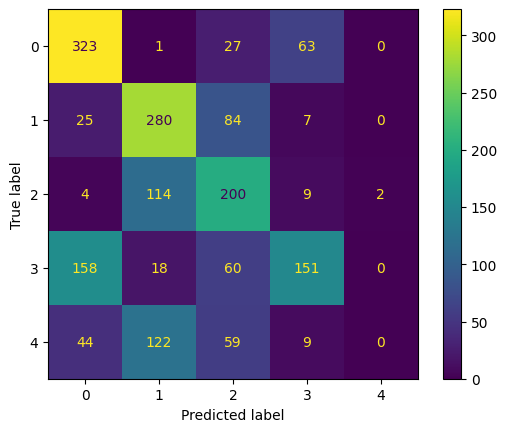

EPOCH: 5


0it [00:00, ?it/s]

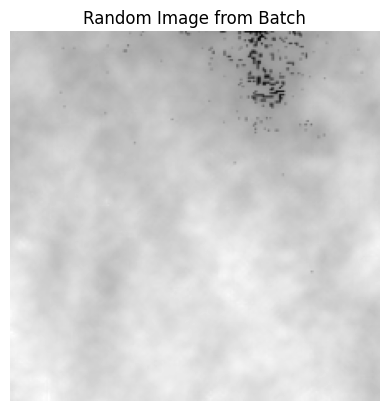

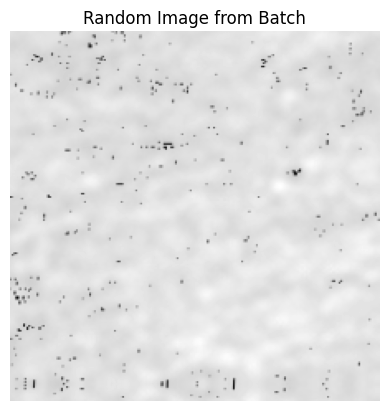

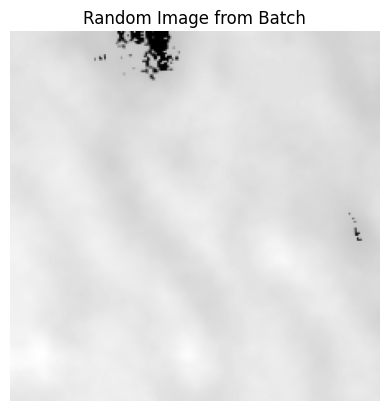

Epoch 5, Train Loss: 1.205, Train Acc: 0.469, 
Epoch 5, Valid Loss: 3.960, Valid Acc: 0.516, 


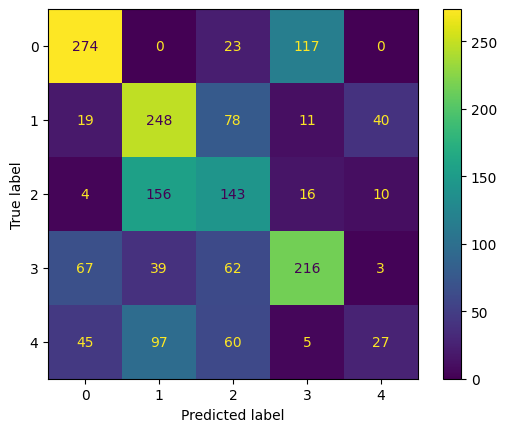

EPOCH: 6


0it [00:00, ?it/s]

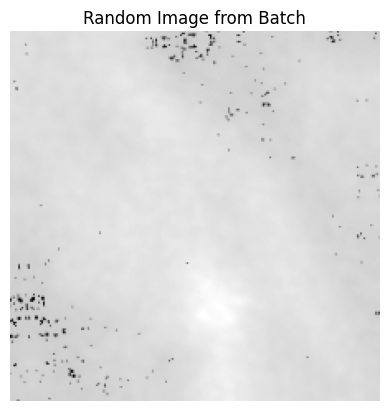

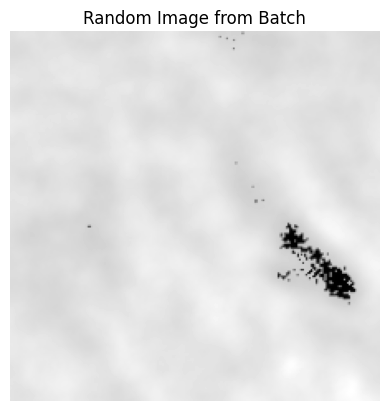

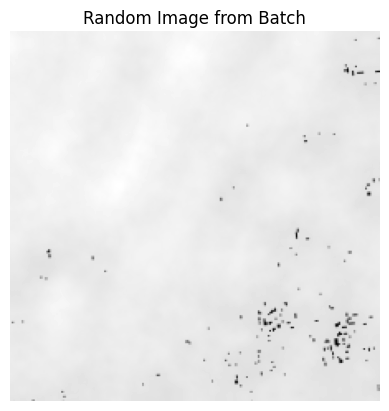

Epoch 6, Train Loss: 1.177, Train Acc: 0.482, 
Epoch 6, Valid Loss: 3.996, Valid Acc: 0.395, 


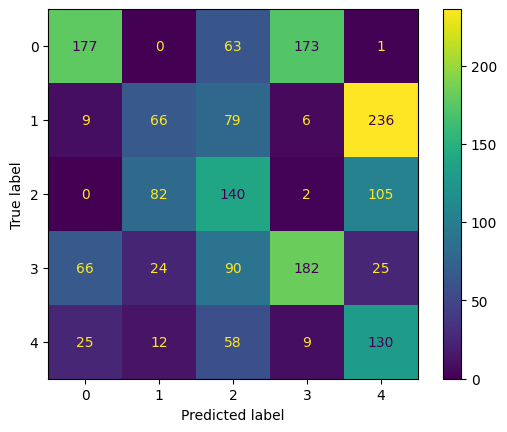

EPOCH: 7


0it [00:00, ?it/s]

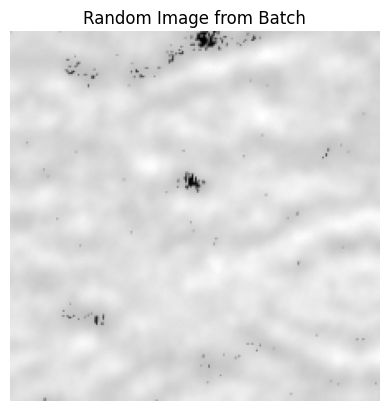

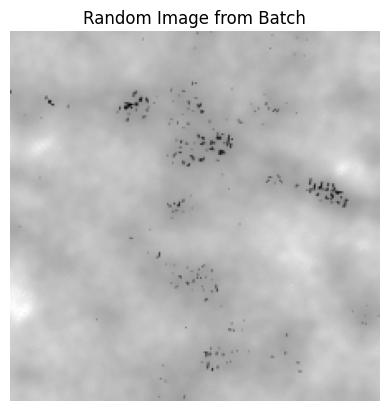

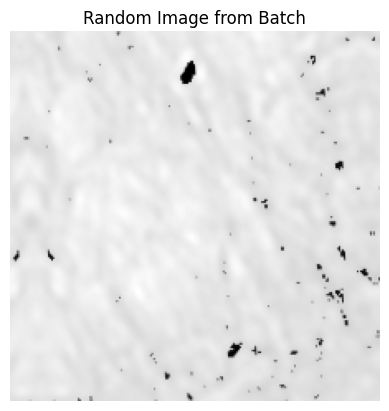

Epoch 7, Train Loss: 1.162, Train Acc: 0.507, 
Epoch 7, Valid Loss: 3.783, Valid Acc: 0.557, 


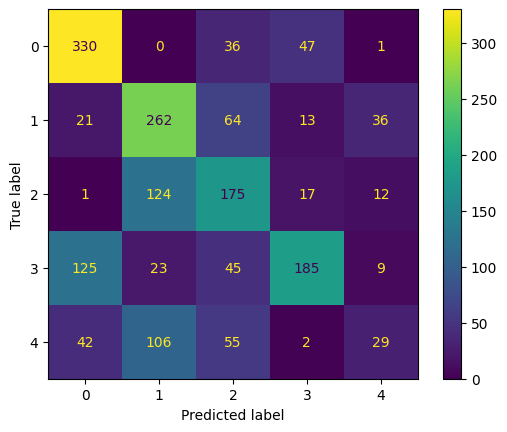

EPOCH: 8


0it [00:00, ?it/s]

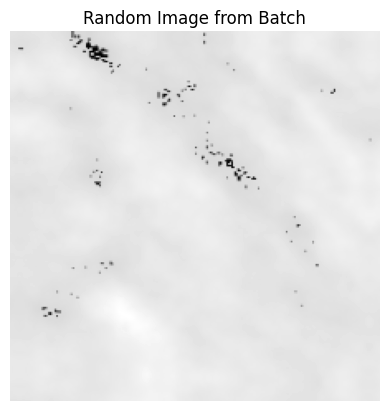

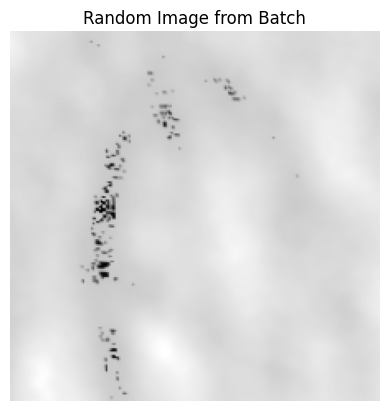

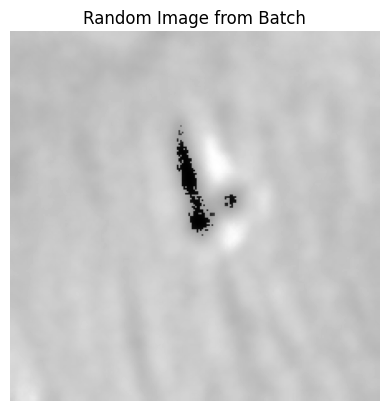

Epoch 8, Train Loss: 1.165, Train Acc: 0.489, 
Epoch 8, Valid Loss: 3.842, Valid Acc: 0.526, 


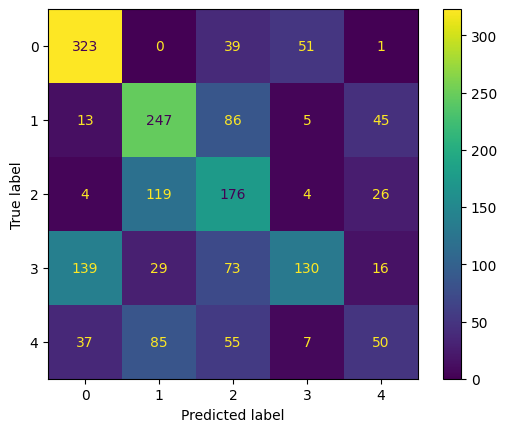

EPOCH: 9


0it [00:00, ?it/s]

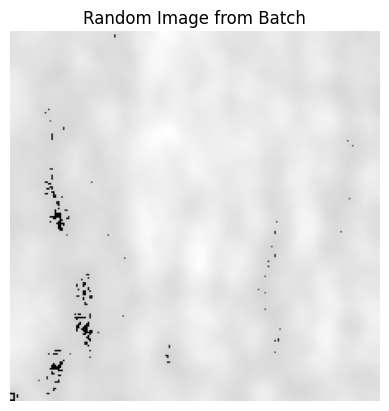

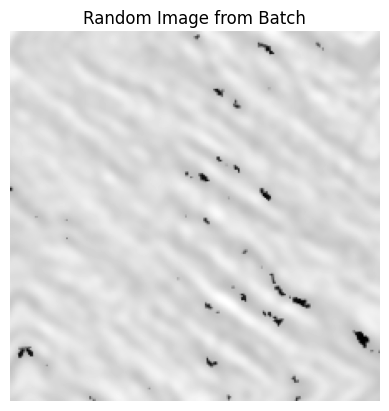

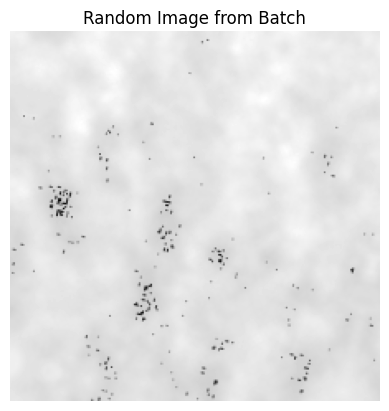

Epoch 9, Train Loss: 1.141, Train Acc: 0.511, 
Epoch 9, Valid Loss: 3.756, Valid Acc: 0.505, 


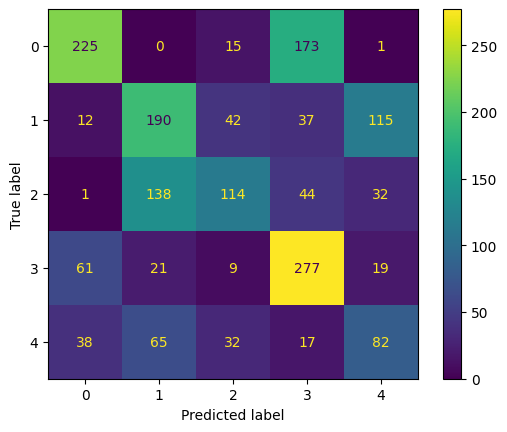

EPOCH: 10


0it [00:00, ?it/s]

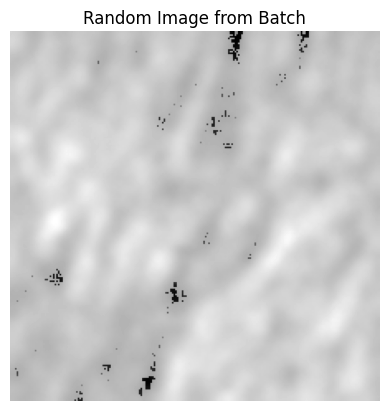

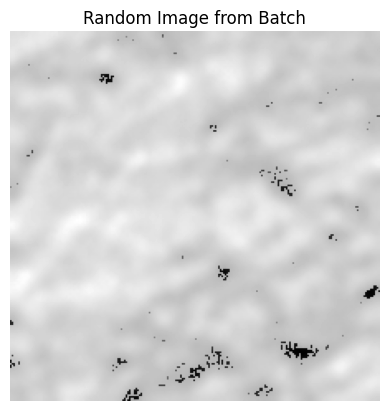

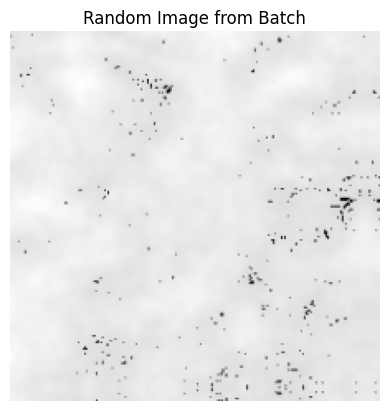

Epoch 10, Train Loss: 1.111, Train Acc: 0.525, 
Epoch 10, Valid Loss: 3.756, Valid Acc: 0.502, 


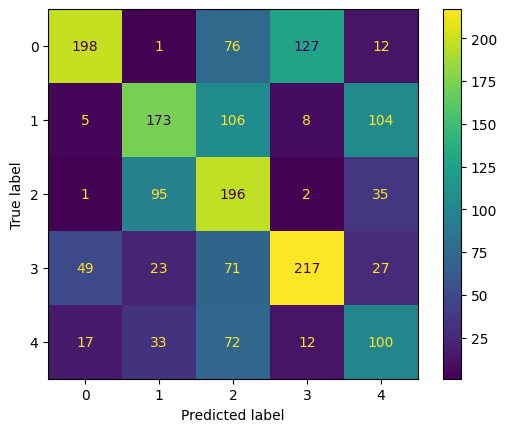

EPOCH: 11


0it [00:00, ?it/s]

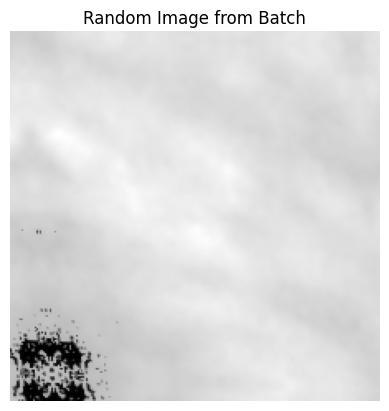

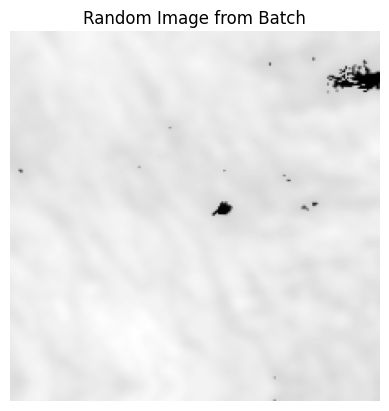

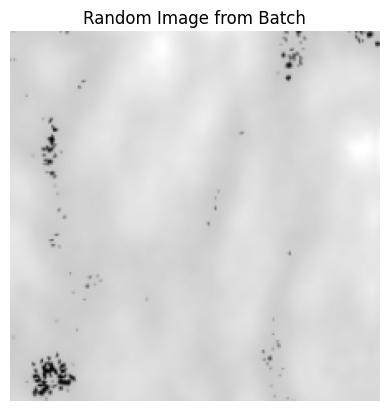

Epoch 11, Train Loss: 1.066, Train Acc: 0.546, 
Epoch 11, Valid Loss: 3.627, Valid Acc: 0.523, 


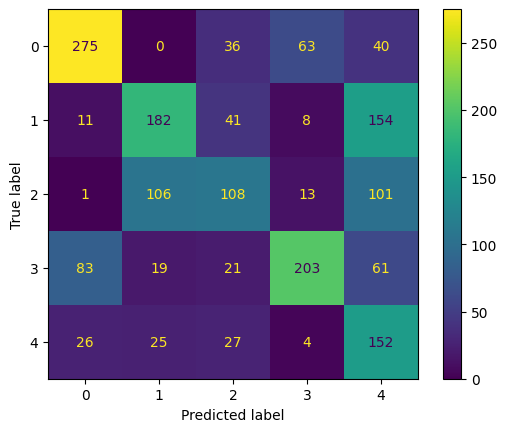

EPOCH: 12


0it [00:00, ?it/s]

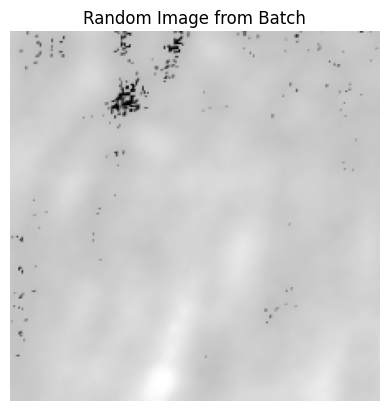

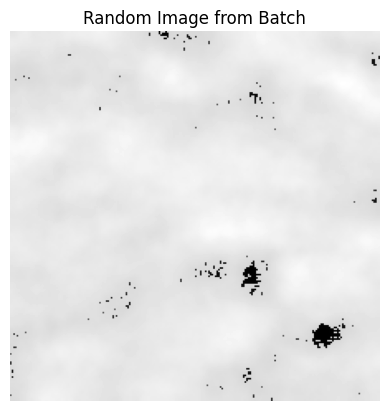

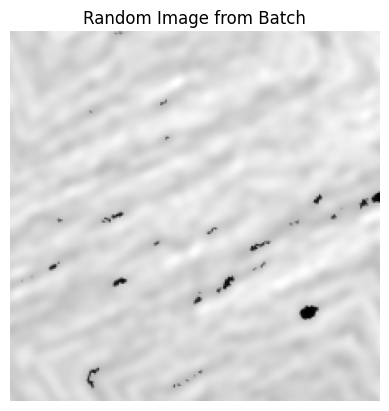

Epoch 12, Train Loss: 1.085, Train Acc: 0.542, 
Epoch 12, Valid Loss: 3.646, Valid Acc: 0.534, 


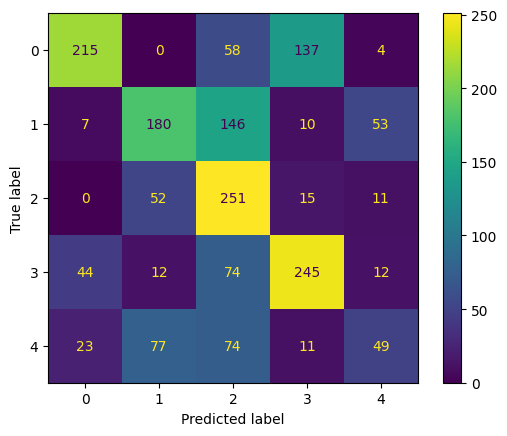

EPOCH: 13


0it [00:00, ?it/s]

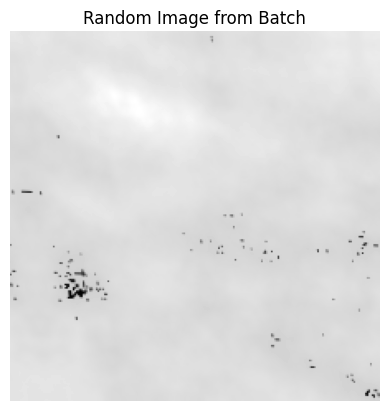

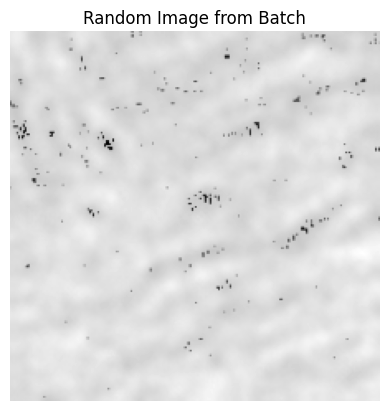

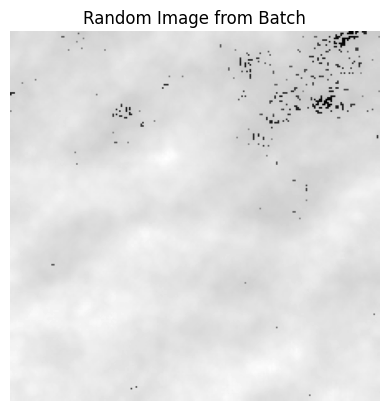

Epoch 13, Train Loss: 1.036, Train Acc: 0.561, 
Epoch 13, Valid Loss: 3.515, Valid Acc: 0.515, 


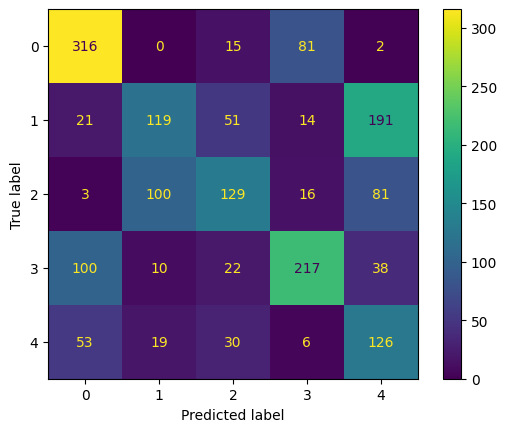

EPOCH: 14


0it [00:00, ?it/s]

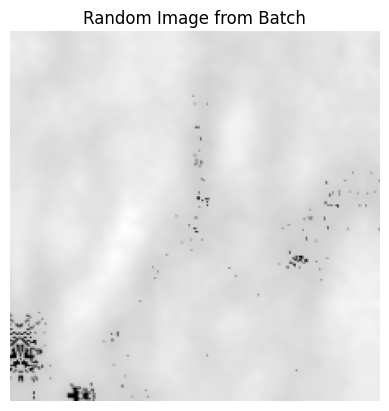

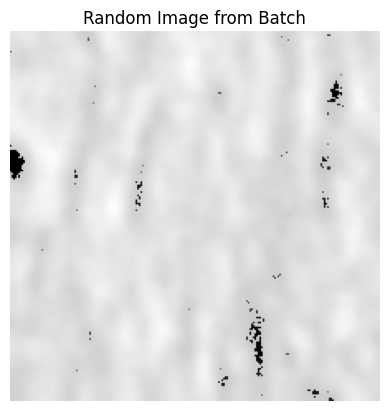

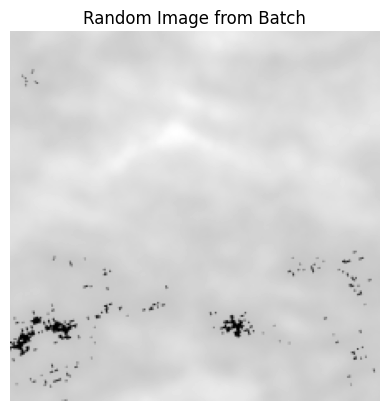

Epoch 14, Train Loss: 1.048, Train Acc: 0.554, 
Epoch 14, Valid Loss: 3.515, Valid Acc: 0.560, 


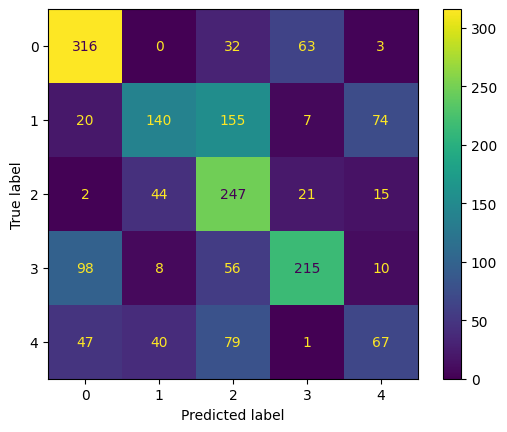

EPOCH: 15


0it [00:00, ?it/s]

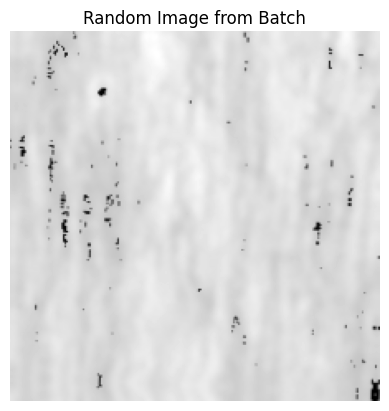

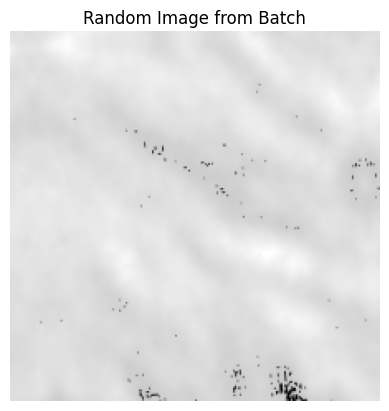

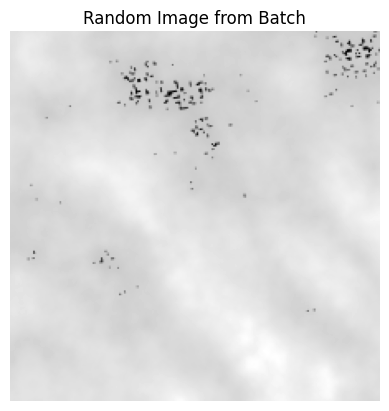

Epoch 15, Train Loss: 1.048, Train Acc: 0.560, 
Epoch 15, Valid Loss: 3.494, Valid Acc: 0.552, 


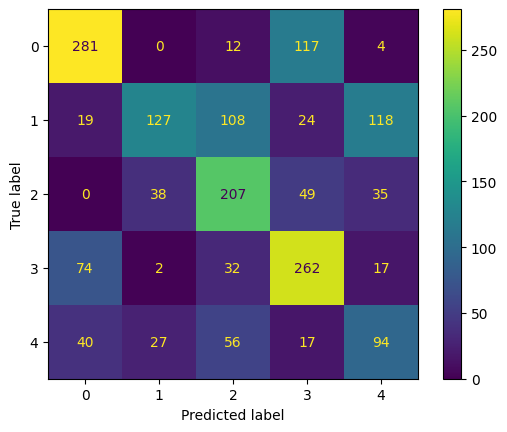

EPOCH: 16


0it [00:00, ?it/s]

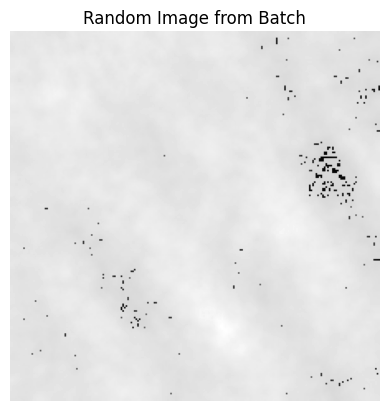

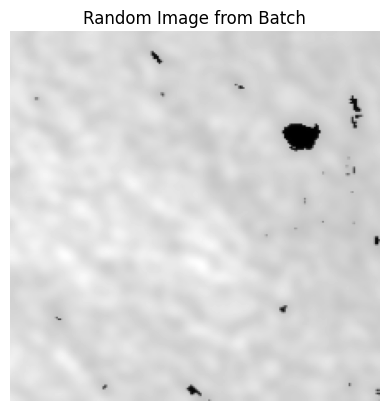

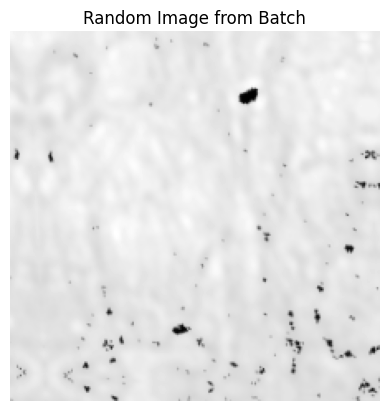

Epoch 16, Train Loss: 0.992, Train Acc: 0.584, 
Epoch 16, Valid Loss: 3.362, Valid Acc: 0.556, 


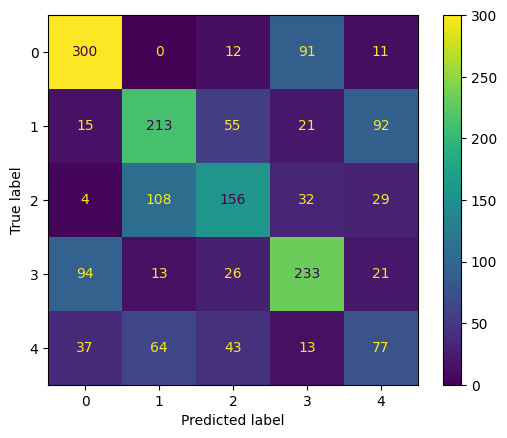

EPOCH: 17


0it [00:00, ?it/s]

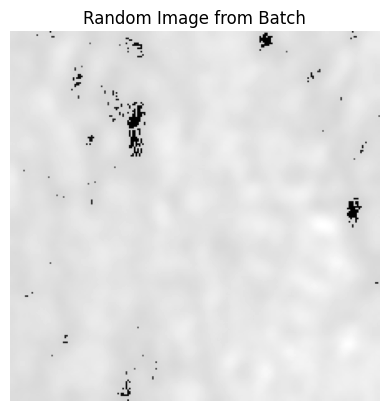

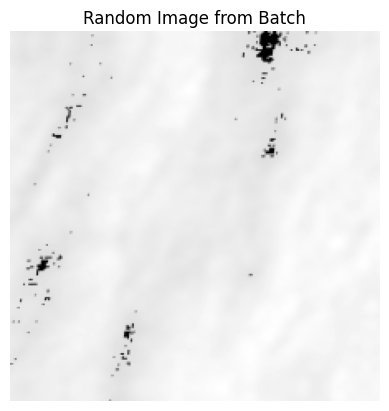

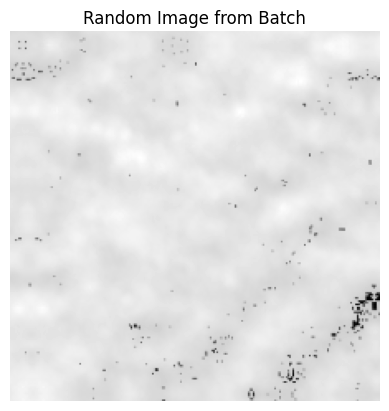

Epoch 17, Train Loss: 0.977, Train Acc: 0.597, 
Epoch 17, Valid Loss: 3.374, Valid Acc: 0.544, 


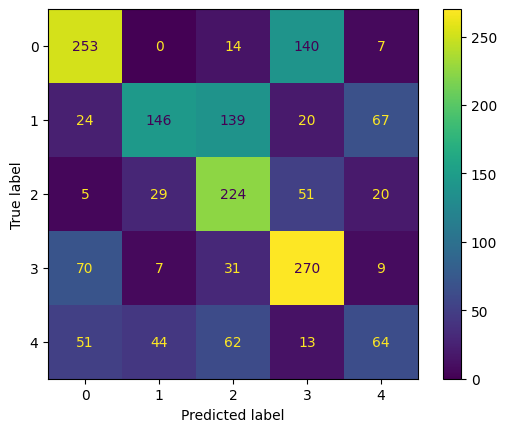

EPOCH: 18


0it [00:00, ?it/s]

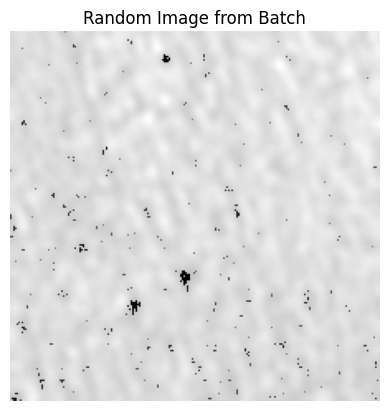

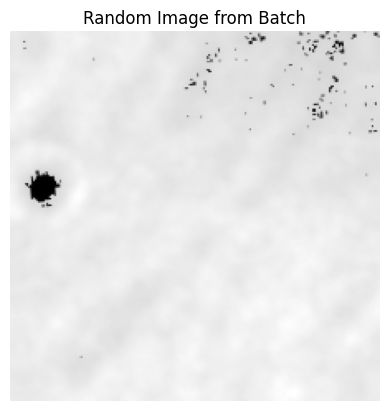

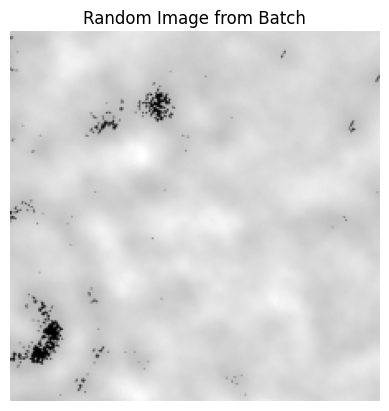

Epoch 18, Train Loss: 0.951, Train Acc: 0.603, 
Epoch 18, Valid Loss: 3.329, Valid Acc: 0.547, 


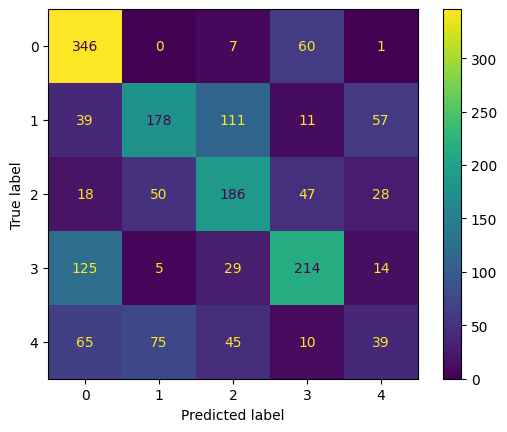

EPOCH: 19


0it [00:00, ?it/s]

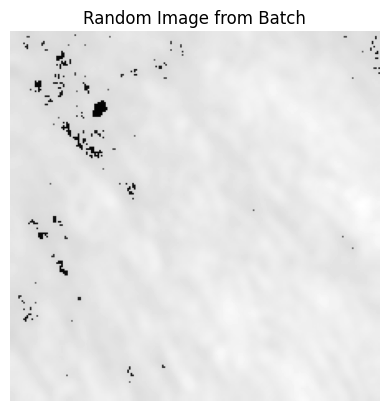

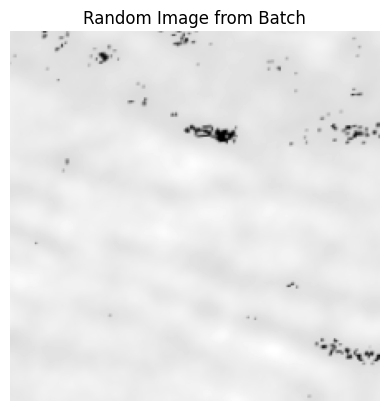

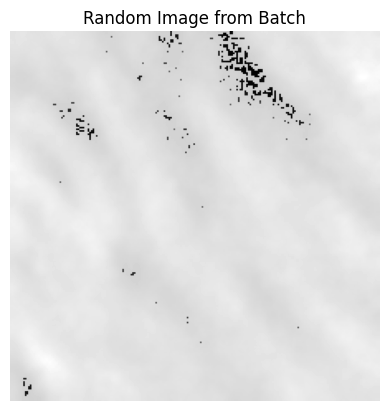

Epoch 19, Train Loss: 0.957, Train Acc: 0.604, 
Epoch 19, Valid Loss: 3.280, Valid Acc: 0.590, 


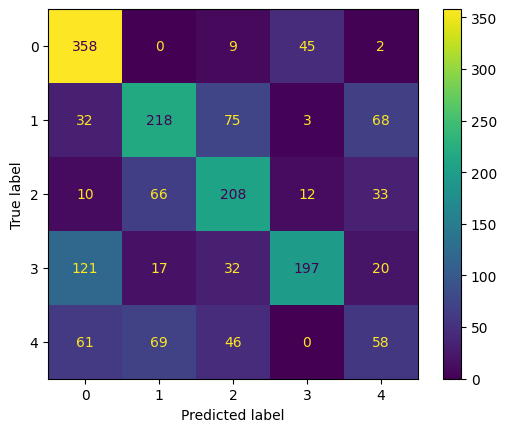

EPOCH: 20


0it [00:00, ?it/s]

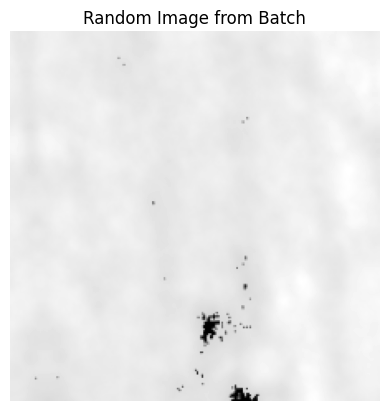

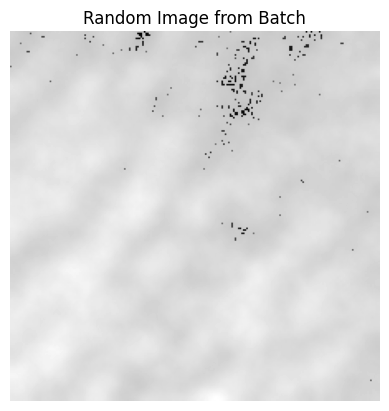

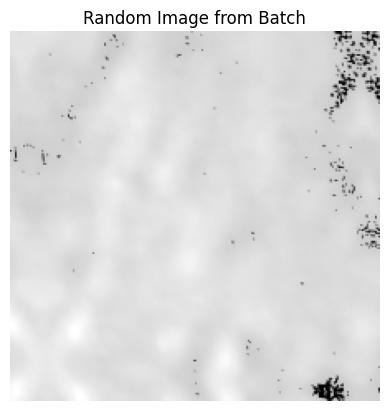

Epoch 20, Train Loss: 0.922, Train Acc: 0.618, 
Epoch 20, Valid Loss: 3.348, Valid Acc: 0.495, 


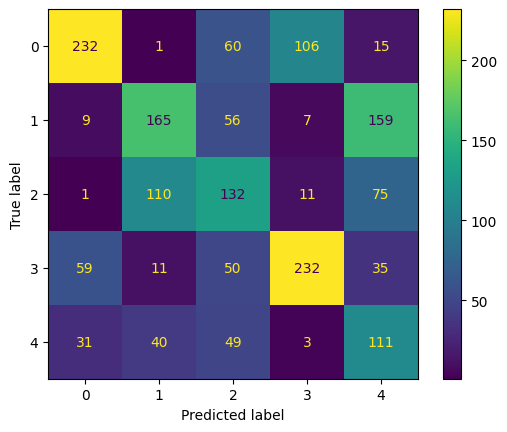

EPOCH: 21


0it [00:00, ?it/s]

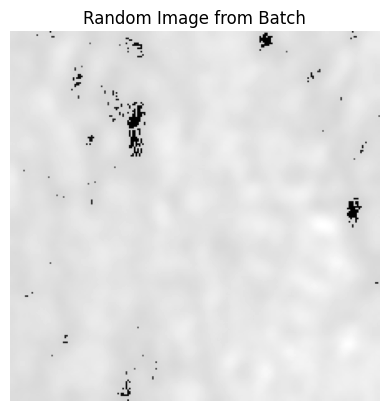

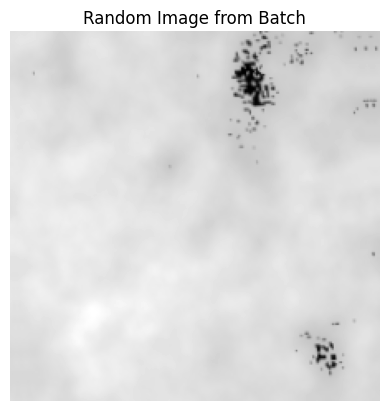

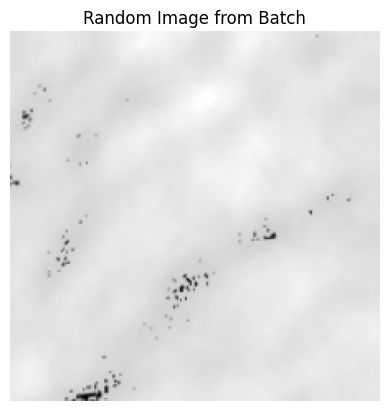

Epoch 21, Train Loss: 0.907, Train Acc: 0.631, 
Epoch 21, Valid Loss: 3.179, Valid Acc: 0.581, 


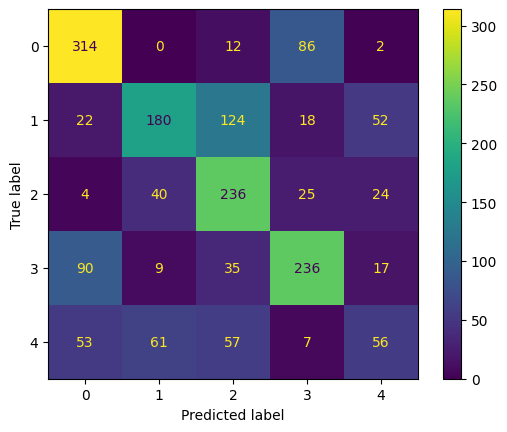

EPOCH: 22


0it [00:00, ?it/s]

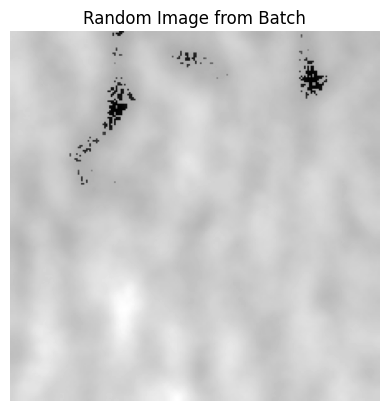

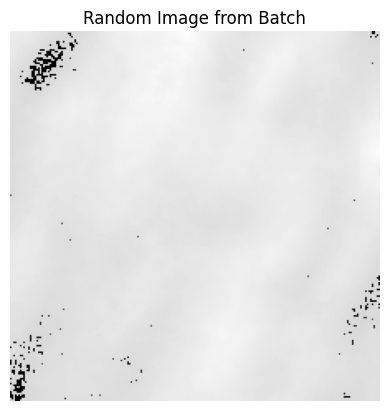

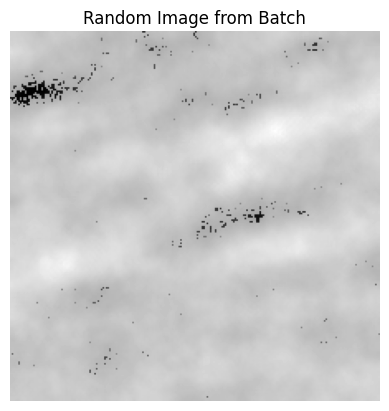

Epoch 22, Train Loss: 0.876, Train Acc: 0.645, 
Epoch 22, Valid Loss: 3.154, Valid Acc: 0.567, 


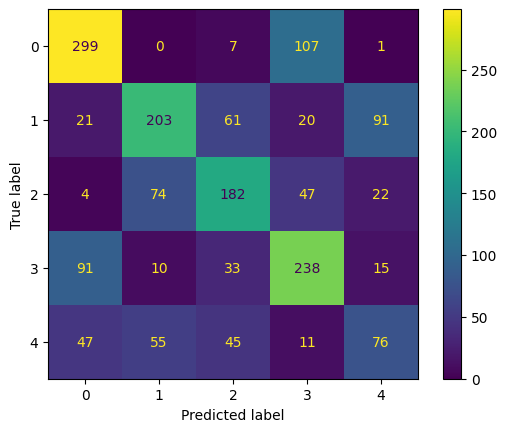

EPOCH: 23


0it [00:00, ?it/s]

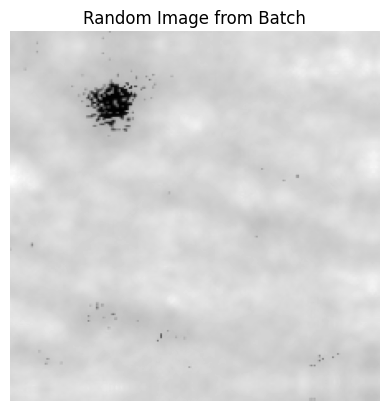

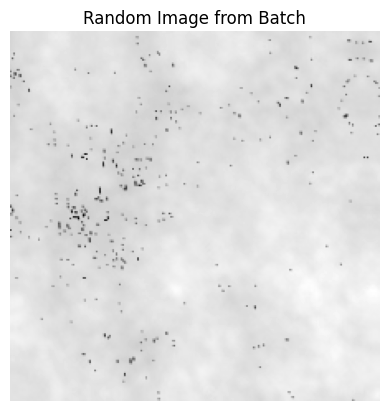

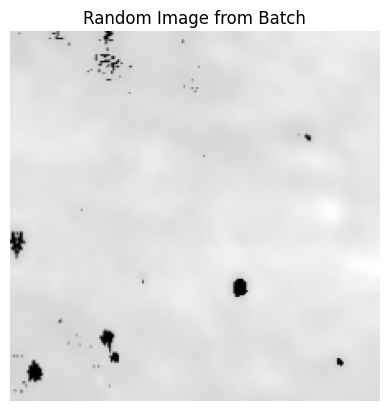

Epoch 23, Train Loss: 0.871, Train Acc: 0.645, 
Epoch 23, Valid Loss: 3.161, Valid Acc: 0.549, 


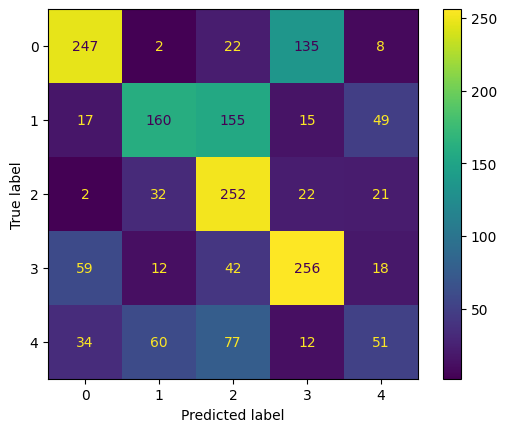

EPOCH: 24


0it [00:00, ?it/s]

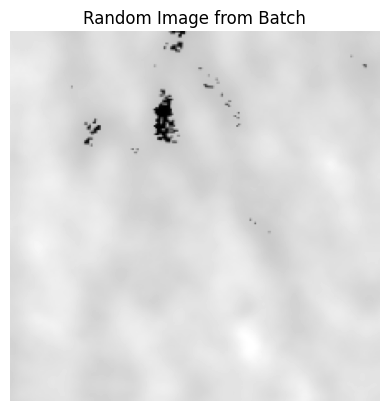

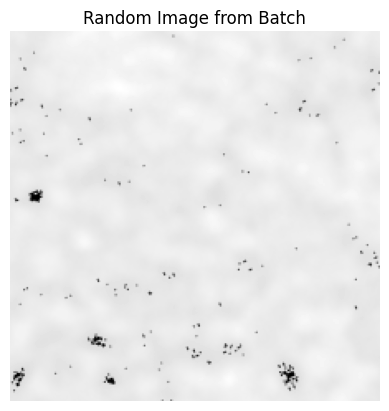

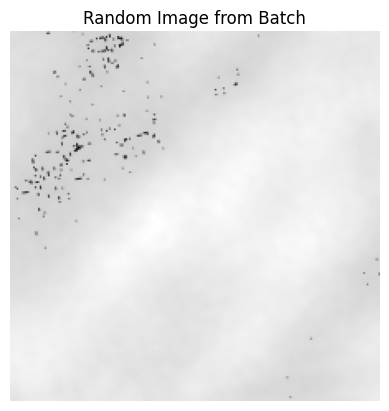

Epoch 24, Train Loss: 0.849, Train Acc: 0.656, 
Epoch 24, Valid Loss: 3.070, Valid Acc: 0.573, 


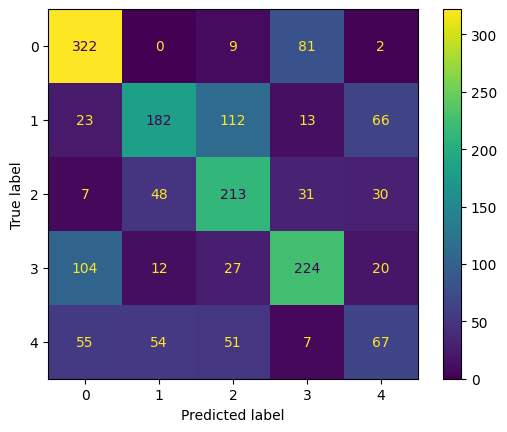

EPOCH: 25


0it [00:00, ?it/s]

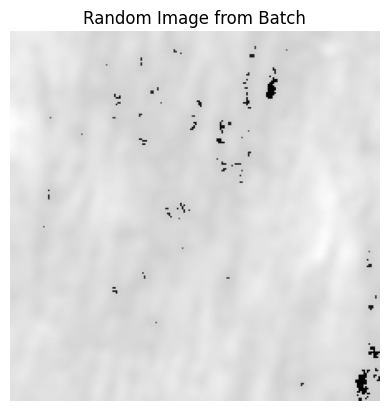

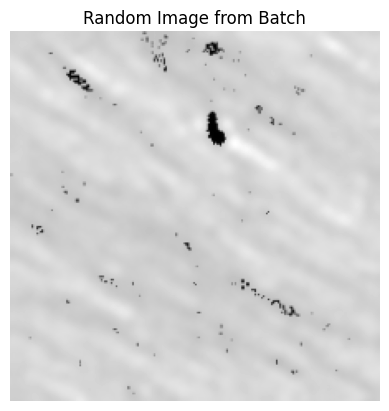

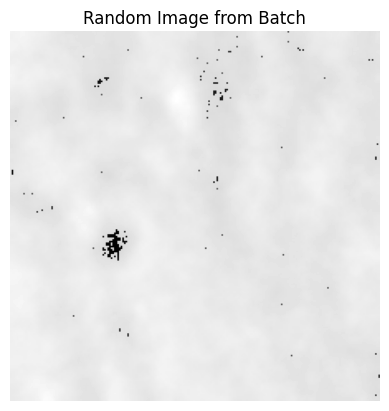

Epoch 25, Train Loss: 0.838, Train Acc: 0.669, 
Epoch 25, Valid Loss: 3.055, Valid Acc: 0.566, 


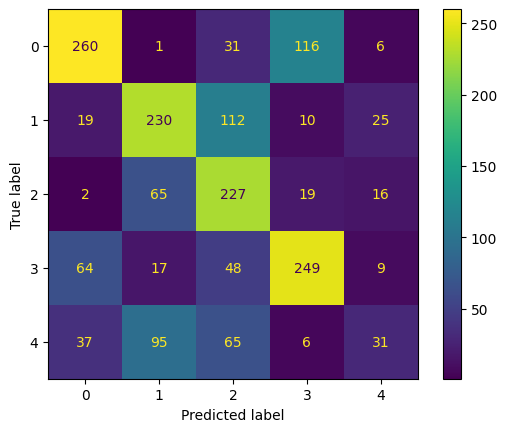

EPOCH: 26


0it [00:00, ?it/s]

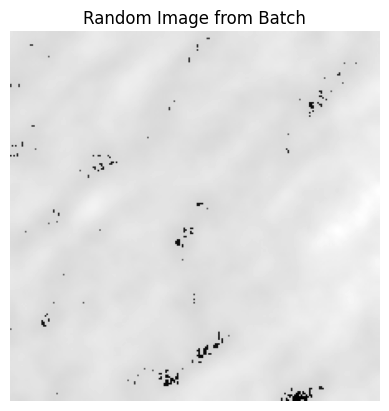

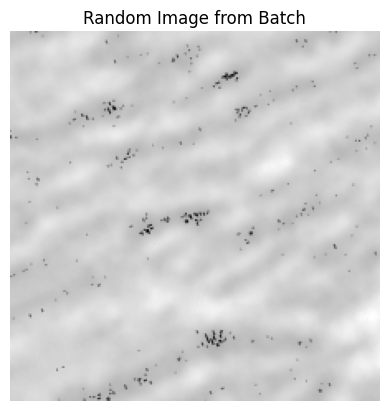

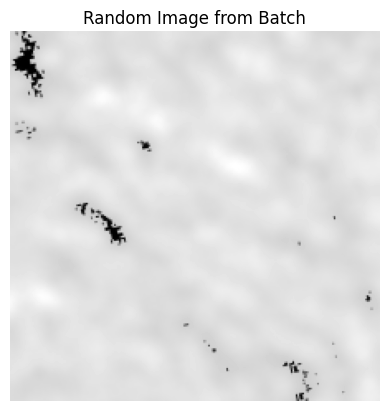

Epoch 26, Train Loss: 0.805, Train Acc: 0.673, 
Epoch 26, Valid Loss: 2.973, Valid Acc: 0.577, 


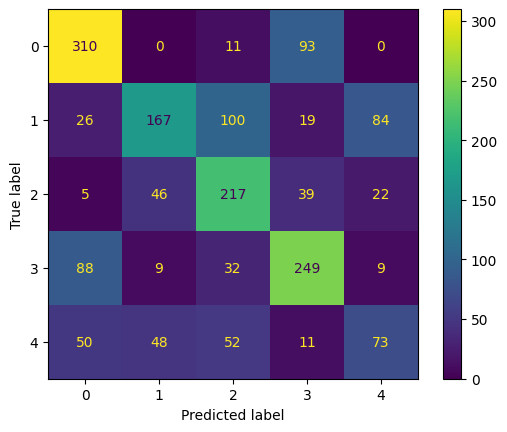

EPOCH: 27


0it [00:00, ?it/s]

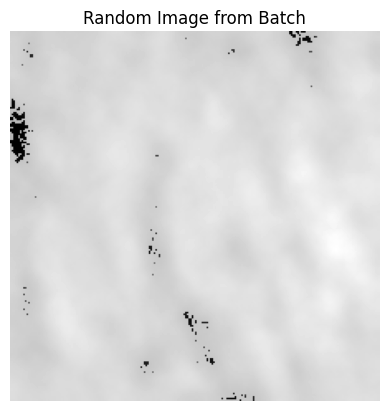

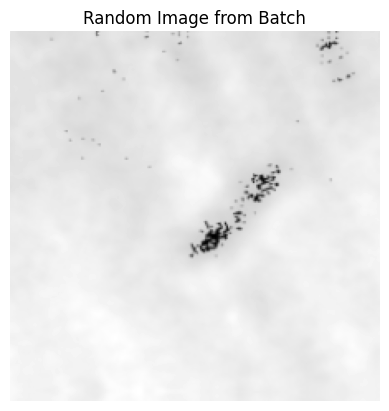

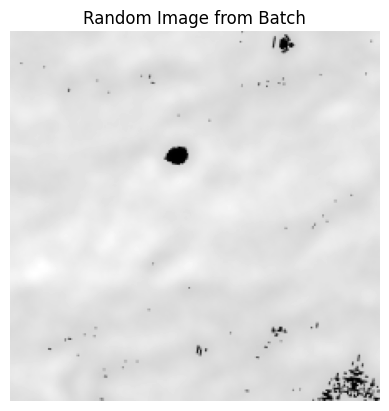

Epoch 27, Train Loss: 0.792, Train Acc: 0.681, 
Epoch 27, Valid Loss: 2.947, Valid Acc: 0.558, 


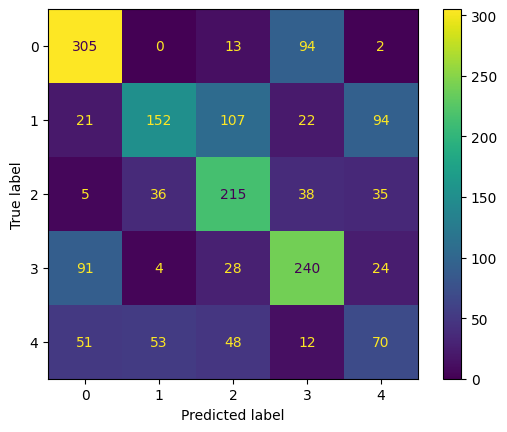

EPOCH: 28


0it [00:00, ?it/s]

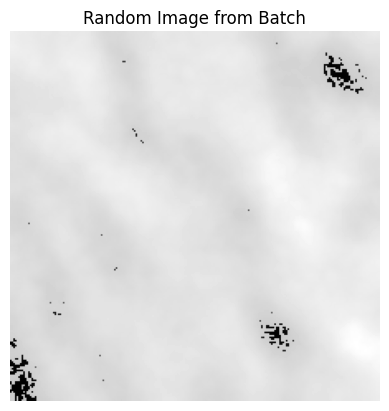

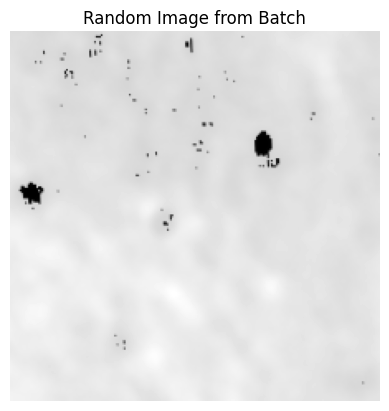

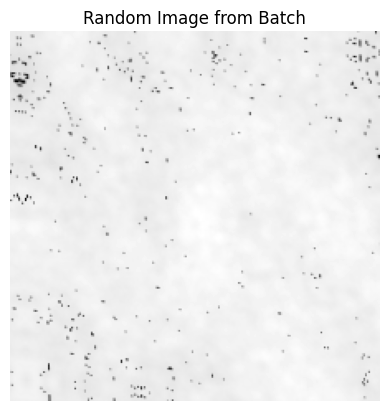

Epoch 28, Train Loss: 0.771, Train Acc: 0.686, 
Epoch 28, Valid Loss: 2.946, Valid Acc: 0.559, 


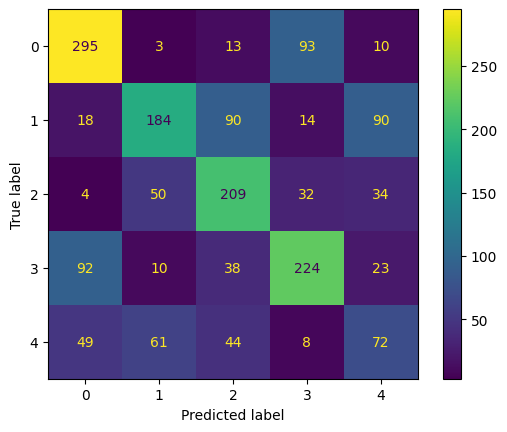

EPOCH: 29


0it [00:00, ?it/s]

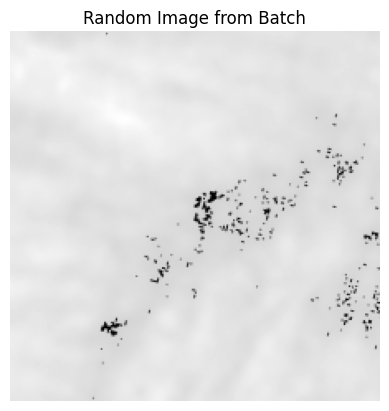

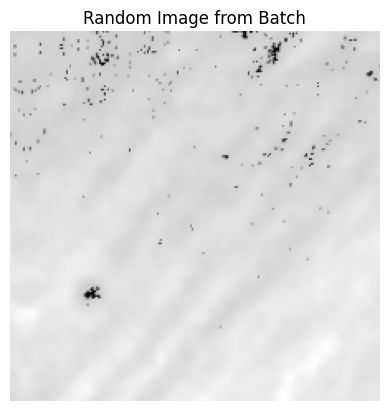

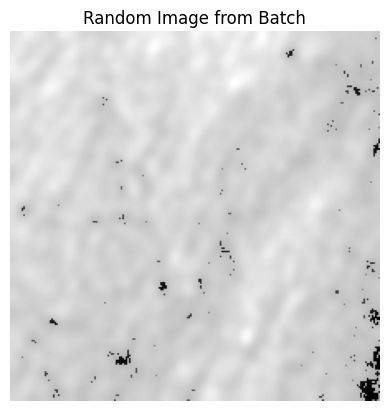

Epoch 29, Train Loss: 0.774, Train Acc: 0.684, 
Epoch 29, Valid Loss: 2.946, Valid Acc: 0.558, 


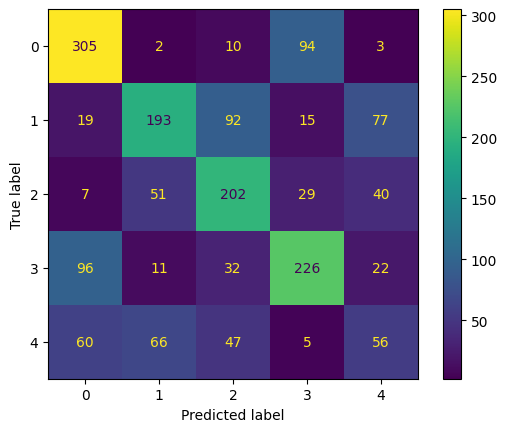

EPOCH: 30


0it [00:00, ?it/s]

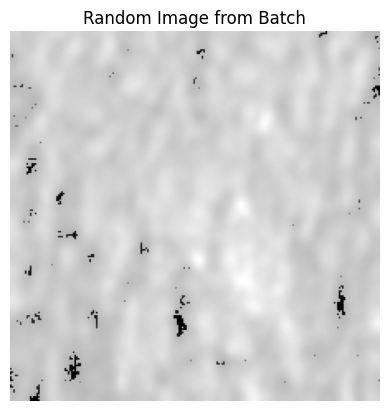

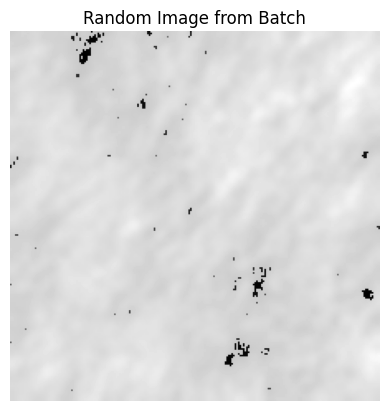

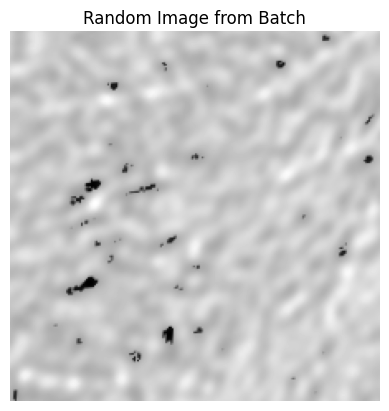

Epoch 30, Train Loss: 0.780, Train Acc: 0.687, 
Epoch 30, Valid Loss: 2.975, Valid Acc: 0.561, 


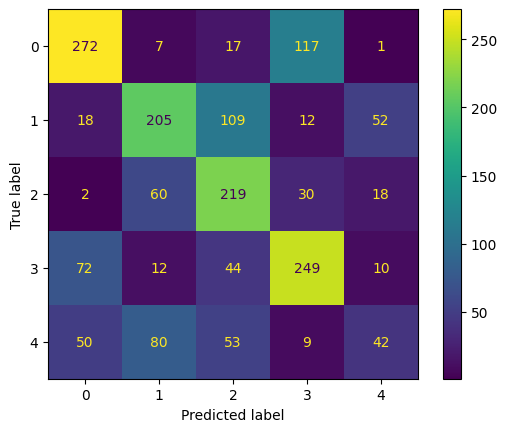

In [21]:
best_loss = float('inf')
epochs_without_improvement = 0
early_stopping_threshold = 5

for epoch in range(30):
    train_loss, train_acc, test_loss, test_acc = train_and_validate(epoch)
    
    if test_loss[-1] < best_loss:
        best_loss = test_loss[-1]
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        
    if epochs_without_improvement >= early_stopping_threshold:
        print("Early stopping triggered after {} epochs without improvement.".format(epochs_without_improvement))
        break

In [22]:
wandb.finish()

## Оценка результатов для полных картинок

In [23]:
def get_predictions():
    """
    возвращает MultiDict, в котором каждому названию картинки соответствует несколько значений
    это предсказания для фрагментов данного изображения
    для каждого изображения будет строчек столько, на сколько фрагментов разбиваем это изображение
    """
    fragments = MultiDict()
    mobilenet_v2_model.eval()
    with torch.no_grad():
        for batch_idx, (data, name, target) in enumerate(valid_dataloader):
            data = data.unsqueeze(1)
            data, target = data.to(device), target.to(device)
            data = data.float()
            outputs = mobilenet_v2_model.to(device)(data)
            preds = outputs.argmax(dim=1)
            
            for n, pred in zip(name, preds):
                fragments.add(n, pred.item())
    return fragments
fragments = get_predictions()

In [24]:
from collections import Counter

def most_common_class_per_key(multidict):
    """
    Получает MultiDict на вход и подсчитывает для одного изображения самый частый предсказанный класс
    Выдает словарь, с названием изображения и самым частым классом
    """
    result = {}
    
    # Получаем уникальные ключи из MultiDict
    keys = set(multidict.keys())
    
    for key in keys:
        values = multidict.getall(key)
        count = Counter(values)
        
        # Получаем самый часто встречающийся класс для текущего ключа
        most_common_class, _ = count.most_common(1)[0]
        result[key] = most_common_class
        
    return result

result = most_common_class_per_key(fragments)

In [25]:
def accuracy_full(result: dict):  
    """
    result - словарь, где каждому пути к изображению сопоставляется самый часто встречаемый класс
    return accuracy - между предсказанными значениями и истинными
    """
    true_val = 0.0
    for key, value in result.items():
        y_true = get_class_from_path(f"'{key}'")
        y_pred = result[key]
        if y_true == y_pred:
            true_val += 1
    accuracy = round(true_val / len(result) * 100, 3)
    return f"Accuracy для полных картинок: {accuracy}%"
accuracy_full(result)

'Accuracy для полных картинок: 61.735%'